### Exploratory Data Analysis
 
With the data now cleaned I will perfom some NLP to extract the features from the Title column from both the Space X and NASA subreddits which will be used to create a model for predicting whether a post originated from Space X or NASA. Prior to proceeding to modeling I will plot some visuals that can provide some insights about the features being chosen for my models. 

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import time
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

### Step # 1: Import the Data

The below dataframe (df_final) is the combined NASA and Space X subreddit posts.

In [2]:
df_final = pd.read_csv('../data/df_final.csv')
df_final.head()

,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,NaN,NaN,False,ElongatedMuskrat,NaN,NaN,contributor,[],NaN,r/SpaceX Bot,...,NaN,NaN,Telstar 18V / APStar 5C Launch Campaign Thread,246,https://www.reddit.com/r/spacex/comments/95cte...,[],NaN,False,all_ads,6
1,NaN,NaN,False,ElongatedMuskrat,NaN,NaN,contributor,[],NaN,r/SpaceX Bot,...,NaN,NaN,"r/SpaceX Discusses [September 2018, #48]",170,https://www.reddit.com/r/spacex/comments/9ckoe...,[],NaN,False,all_ads,6
2,NaN,NaN,False,soldato_fantasma,NaN,NaN,contributor,[],NaN,Host of BulgariaSat-1,...,84.0,140.0,SpaceX granted patents for custom-built Starli...,916,https://www.teslarati.com/spacex-custom-built-...,[],NaN,False,all_ads,6
3,NaN,NaN,False,jclishman,NaN,NaN,contributor,[],NaN,Host of Inmarsat-5 Flight 4,...,140.0,140.0,"Jeff Foust on Twitter - ""Shotwell: think we’ll...",210,https://twitter.com/jeff_foust/status/10378148...,[],NaN,False,all_ads,6
4,NaN,NaN,False,Bossdude234,NaN,NaN,NaN,[],NaN,NaN,...,140.0,140.0,"SpaceX on Twitter - ""Now targeting September 9...",79,https://twitter.com/SpaceX/status/103784391187...,[],NaN,False,all_ads,6


### Step # 2:  Instantiate and fit CountVectorizer

Using the CountVectorizer feature extraction method I can get a summed count of each vocabulary word within each subreddit post for Space X and NASA. This will allow for continued EDA on which specific vocabulary words are being used most often within the posts. Knowing this data we can get the optimal features (vocabulary words) to create a final dataframe for the modeling process.

#### Hyperparameter Description

To assit in getting the most optimal vocabulary words or phrases I will ensure the CountVectorizer does the following:
- Removes basic words that are common in the english language
    - stop_words = 'english'
- Looks through each word and each word that follows the word as seperate features
    - ngram_range = (1,2)
        - Example: falcon / falcon heavy
- Ensure that we only perform a count on words that appear in at least 5 posts
    - min_df = 5

In [3]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5)

In [4]:
cvec_mat = cvec.fit_transform(df_final['title'])

In [5]:
len(cvec.get_feature_names())

1083

In [6]:
cvec_df = pd.DataFrame(cvec_mat.toarray(), columns=cvec.get_feature_names())

In [7]:
cvec_df.head()

,000,10,100,11,12,13,14,15,16,17,...,working,world,worlds,year,year old,years,years ago,yesterday,zone,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Interpretation (Space X)

In order to analyze the vocabulary words being used within each post I will add in a column that puts in our target variable so that we can understand which words are appearing within the posts of Space X and NASA.

After performing the CountVectorizer using a bar plot I can visually analyze which vocabulary words are appearing within the Space X subreddit posts with a comparison of those same words to the amount of times they are appearing within the NASA subreddit posts.

Some noteworthy vocabulary words appearing in the Space X subreddit posts:
- Falcon : 326 mentions of this vocabulary word
- Launch : 254 mentions of this vocabulary word
- Falcon Heavy : 112 mentions of this vocaulary word

In [8]:
cvec_df['subreddit'] = df_final['subreddit'].values

In [9]:
cvec_spacex_sum_df = cvec_df.groupby('subreddit').sum().T.sort_values('spacex', ascending=False).head(10)
cvec_spacex_sum_df

subreddit,nasa,spacex
spacex,20,528
falcon,5,326
launch,78,254
heavy,11,118
falcon heavy,3,112
space,210,106
crew,19,104
dragon,9,98
nasa,440,87
block,4,83


In [10]:
cvec_spacex_sum_df[['spacex']].T.values[0]

array([528, 326, 254, 118, 112, 106, 104,  98,  87,  83], dtype=int64)

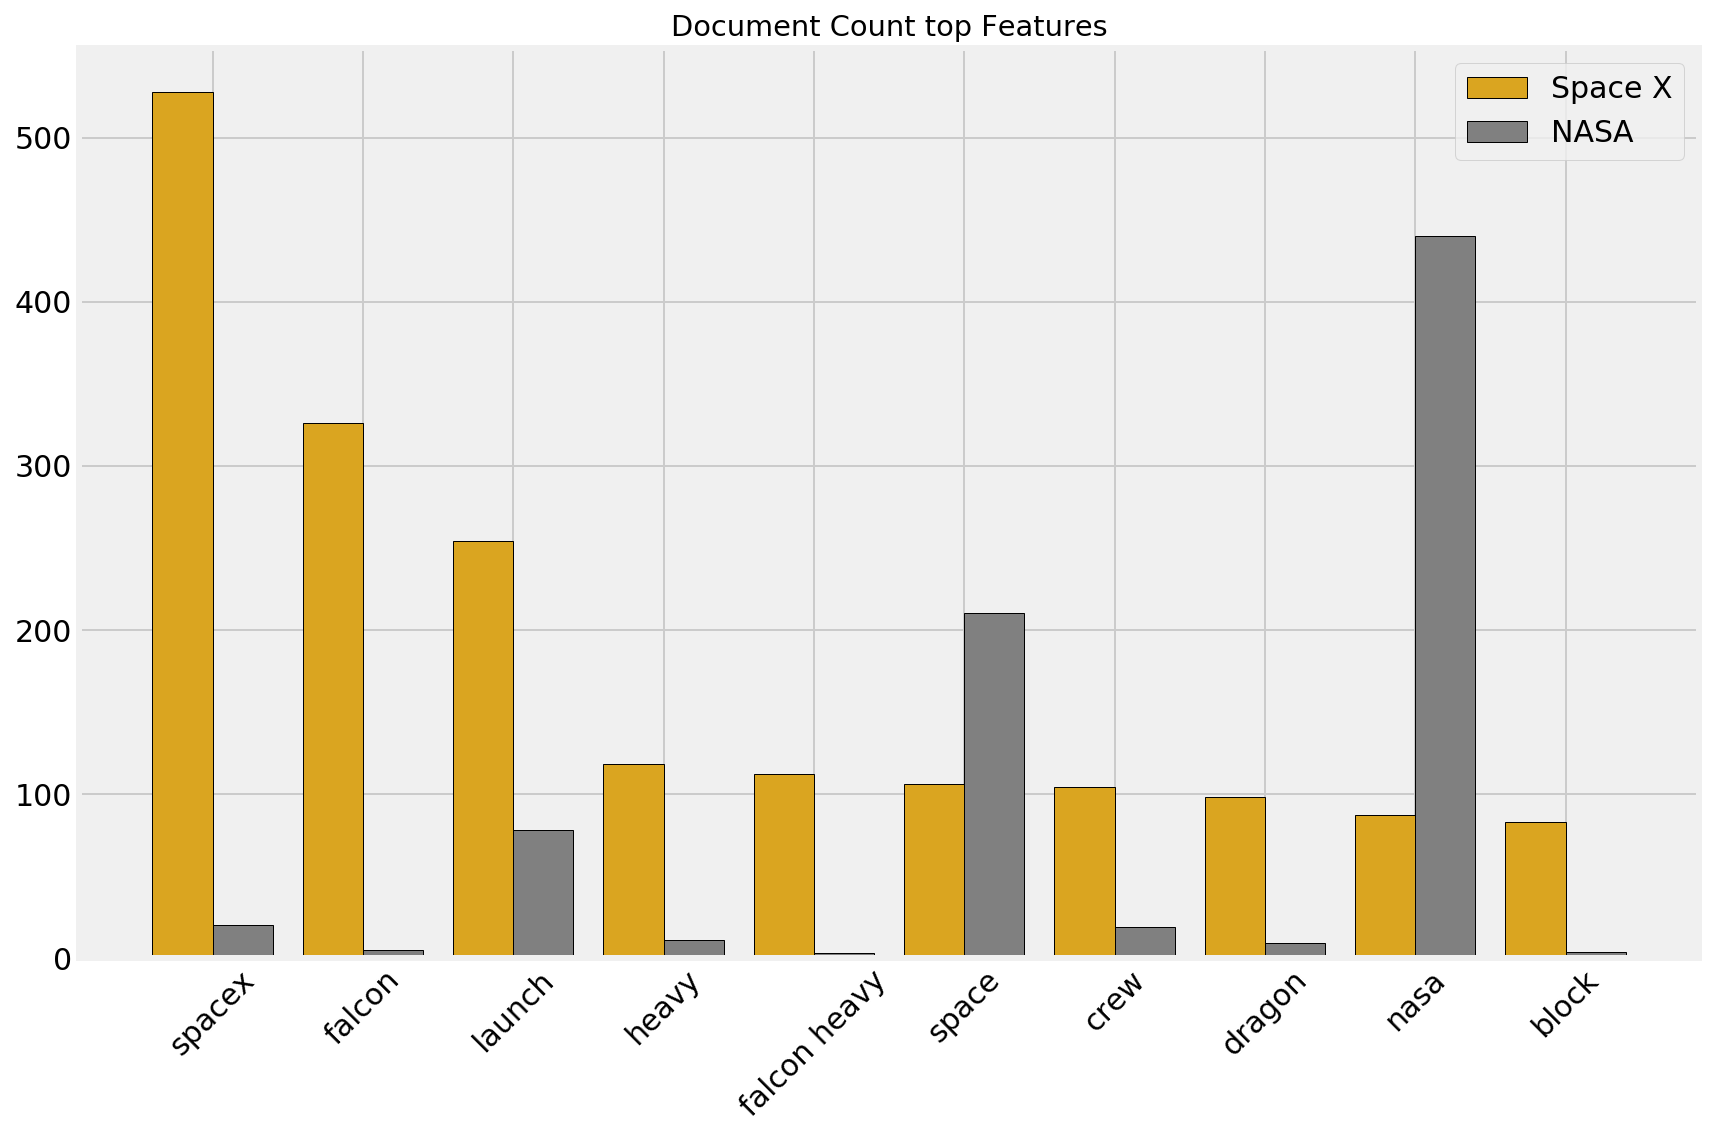

In [11]:
plt.figure(figsize=(12,8))
locs, labels = plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.setp(labels, rotation=45)
plt.title('Document Count top Features')
plt.bar(cvec_spacex_sum_df.index, cvec_spacex_sum_df[['spacex']].T.values[0], alpha=1, align='edge', width=-.4, ec='k', color='goldenrod')
plt.bar(cvec_spacex_sum_df.index, cvec_spacex_sum_df[['nasa']].T.values[0], alpha=1, align='edge', width=.4, ec='k', color='grey')
plt.legend(['Space X', 'NASA'], prop={'size': 15})
plt.tight_layout();
plt.savefig('../plots/cvec_sorted_spacex')

#### Additional Analysis

I can also take an average of these words within all of the posts to understand in what proportion of the subreddit posts these words are appearing.

The noteworthy vocabulary words I pointed out previously from the Space X subreddit posts:
- Falcon : Appears in 26.69 % of the posts
- Launch : Appears in 20.80 % of the posts
- Falcon Heavy : Appears in 9.17 % of the posts

In [12]:
cvec_spacex_mean_df = cvec_df.groupby('subreddit').mean().T.sort_values('spacex', ascending=False).head(10)
cvec_spacex_mean_df

subreddit,nasa,spacex
spacex,0.016300,0.432432
falcon,0.004075,0.266994
launch,0.063570,0.208026
heavy,0.008965,0.096642
falcon heavy,0.002445,0.091728
space,0.171149,0.086814
crew,0.015485,0.085176
dragon,0.007335,0.080262
nasa,0.358598,0.071253
block,0.003260,0.067977


In [13]:
cvec_spacex_mean_df[['spacex']].T.values[0]

array([0.43243243, 0.26699427, 0.20802621, 0.0966421 , 0.09172809,
       0.08681409, 0.08517609, 0.08026208, 0.07125307, 0.06797707])

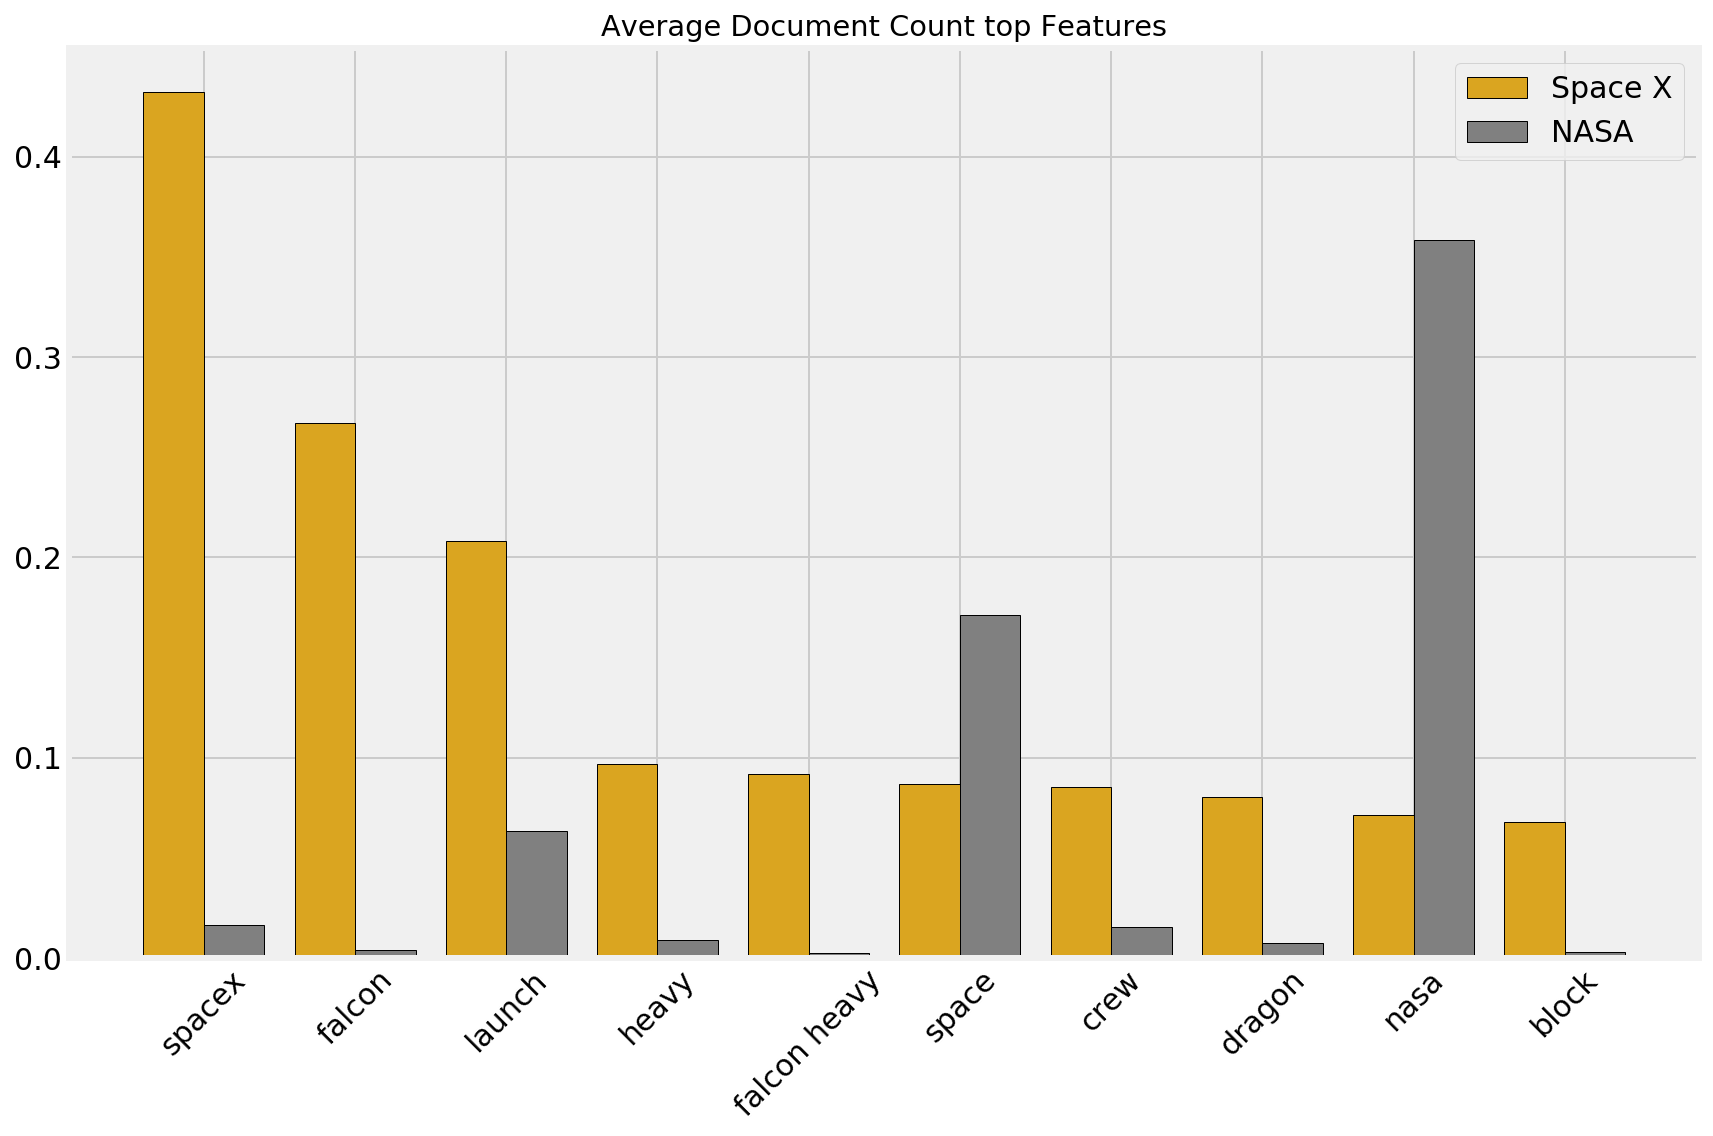

In [14]:
plt.figure(figsize=(12,8))
locs, labels = plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.setp(labels, rotation=45)
plt.title('Average Document Count top Features')
plt.bar(cvec_spacex_mean_df.index, cvec_spacex_mean_df[['spacex']].T.values[0], alpha=1, align='edge', width=-.4, ec='k', color='goldenrod')
plt.bar(cvec_spacex_mean_df.index, cvec_spacex_mean_df[['nasa']].T.values[0], alpha=1, align='edge', width=.4, ec='k', color='grey')
plt.legend(['Space X', 'NASA'], prop={'size': 15})
plt.tight_layout();
plt.savefig('../plots/cvec_mean_sorted_spacex')

#### Interpretation (NASA)

After performing the CountVectorizer using a bar plot I can visually analyze which vocabulary words are appearing within the NASA subreddit posts with a comparison of those same words to the amount of times they are appearing within the Space X subreddit posts.

Some noteworthy vocabulary words appearing in the NASA subreddit posts:
- Mars : 101 mentions of this vocabulary word
- Launch : 78 mentions of this vocabulary word
- Moon : 77 mentions of this vocabulary word
- Apollo : 55 mentions of this vocaulary word

In [15]:
cvec_nasa_sum_df = cvec_df.groupby('subreddit').sum().T.sort_values('nasa', ascending=False).head(10)
cvec_nasa_sum_df

subreddit,nasa,spacex
nasa,440,87
space,210,106
mars,101,52
launch,78,254
moon,77,14
apollo,55,1
center,50,16
mission,50,50
saturn,44,0
space station,43,12


In [16]:
cvec_nasa_sum_df[['spacex']].T.values[0]

array([ 87, 106,  52, 254,  14,   1,  16,  50,   0,  12], dtype=int64)

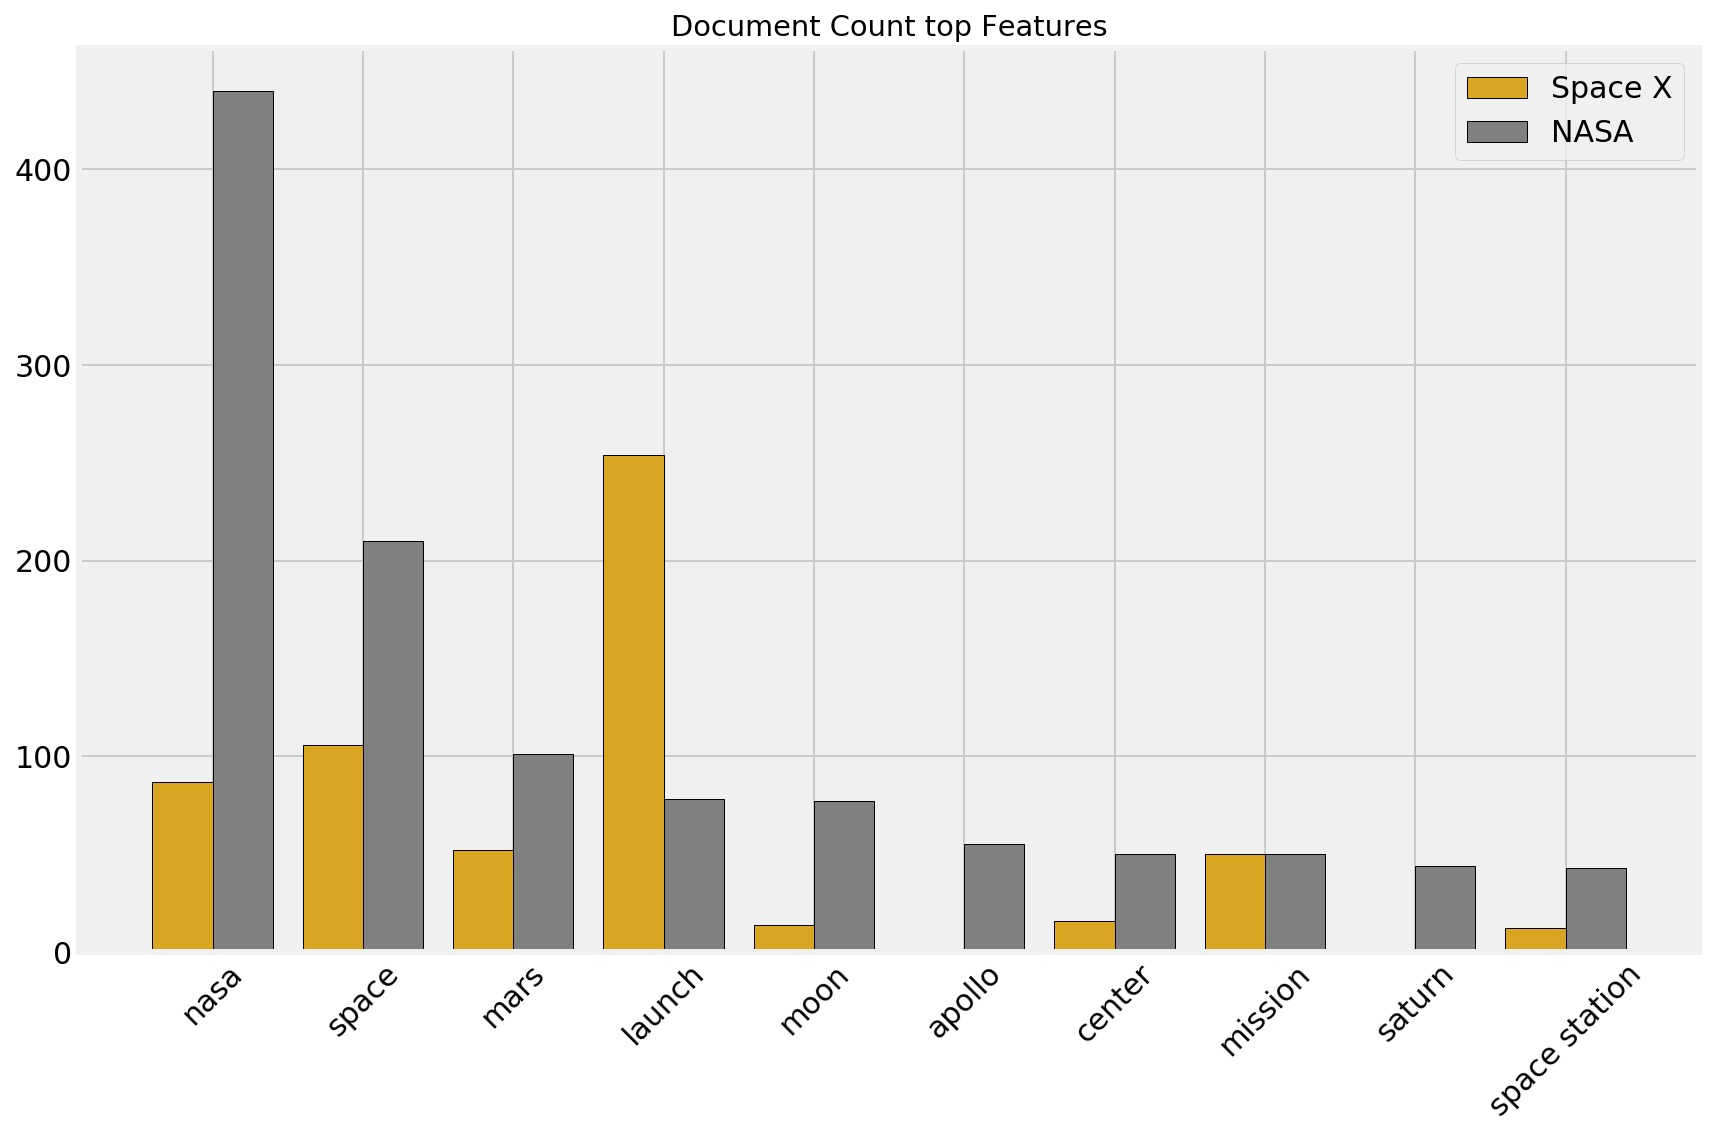

In [17]:
plt.figure(figsize=(12,8))
locs, labels = plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.setp(labels, rotation=45)
plt.title('Document Count top Features')
plt.bar(cvec_nasa_sum_df.index, cvec_nasa_sum_df[['spacex']].T.values[0], alpha=1, align='edge', width=-.4, ec='k', color='goldenrod')
plt.bar(cvec_nasa_sum_df.index, cvec_nasa_sum_df[['nasa']].T.values[0], alpha=1, align='edge', width=.4, ec='k', color='grey')
plt.legend(['Space X', 'NASA'], prop={'size': 15})
plt.tight_layout();
plt.savefig('../plots/cvec_sorted_nasa')

#### Additional Analysis

I can also take an average of these words within all of the posts to understand in what proportion of the subreddit posts these words are appearing.

The noteworthy vocabulary words I pointed out previously from the NASA subreddit posts:
- Mars : Appears in 8.23 % of the posts
- Launch : Appears in 6.35 % of the posts
- Moon : Appears in 6.27 % of the posts
- Apollo : Appears in 4.48 % of the posts

In [18]:
cvec_nasa_mean_df = cvec_df.groupby('subreddit').mean().T.sort_values('nasa', ascending=False).head(10)
cvec_nasa_mean_df

subreddit,nasa,spacex
nasa,0.358598,0.071253
space,0.171149,0.086814
mars,0.082315,0.042588
launch,0.063570,0.208026
moon,0.062755,0.011466
apollo,0.044825,0.000819
center,0.040750,0.013104
mission,0.040750,0.040950
saturn,0.035860,0.000000
space station,0.035045,0.009828


In [19]:
cvec_nasa_mean_df[['nasa']].T.values[0]

array([0.35859821, 0.17114914, 0.08231459, 0.06356968, 0.06275469,
       0.04482478, 0.0407498 , 0.0407498 , 0.03585982, 0.03504482])

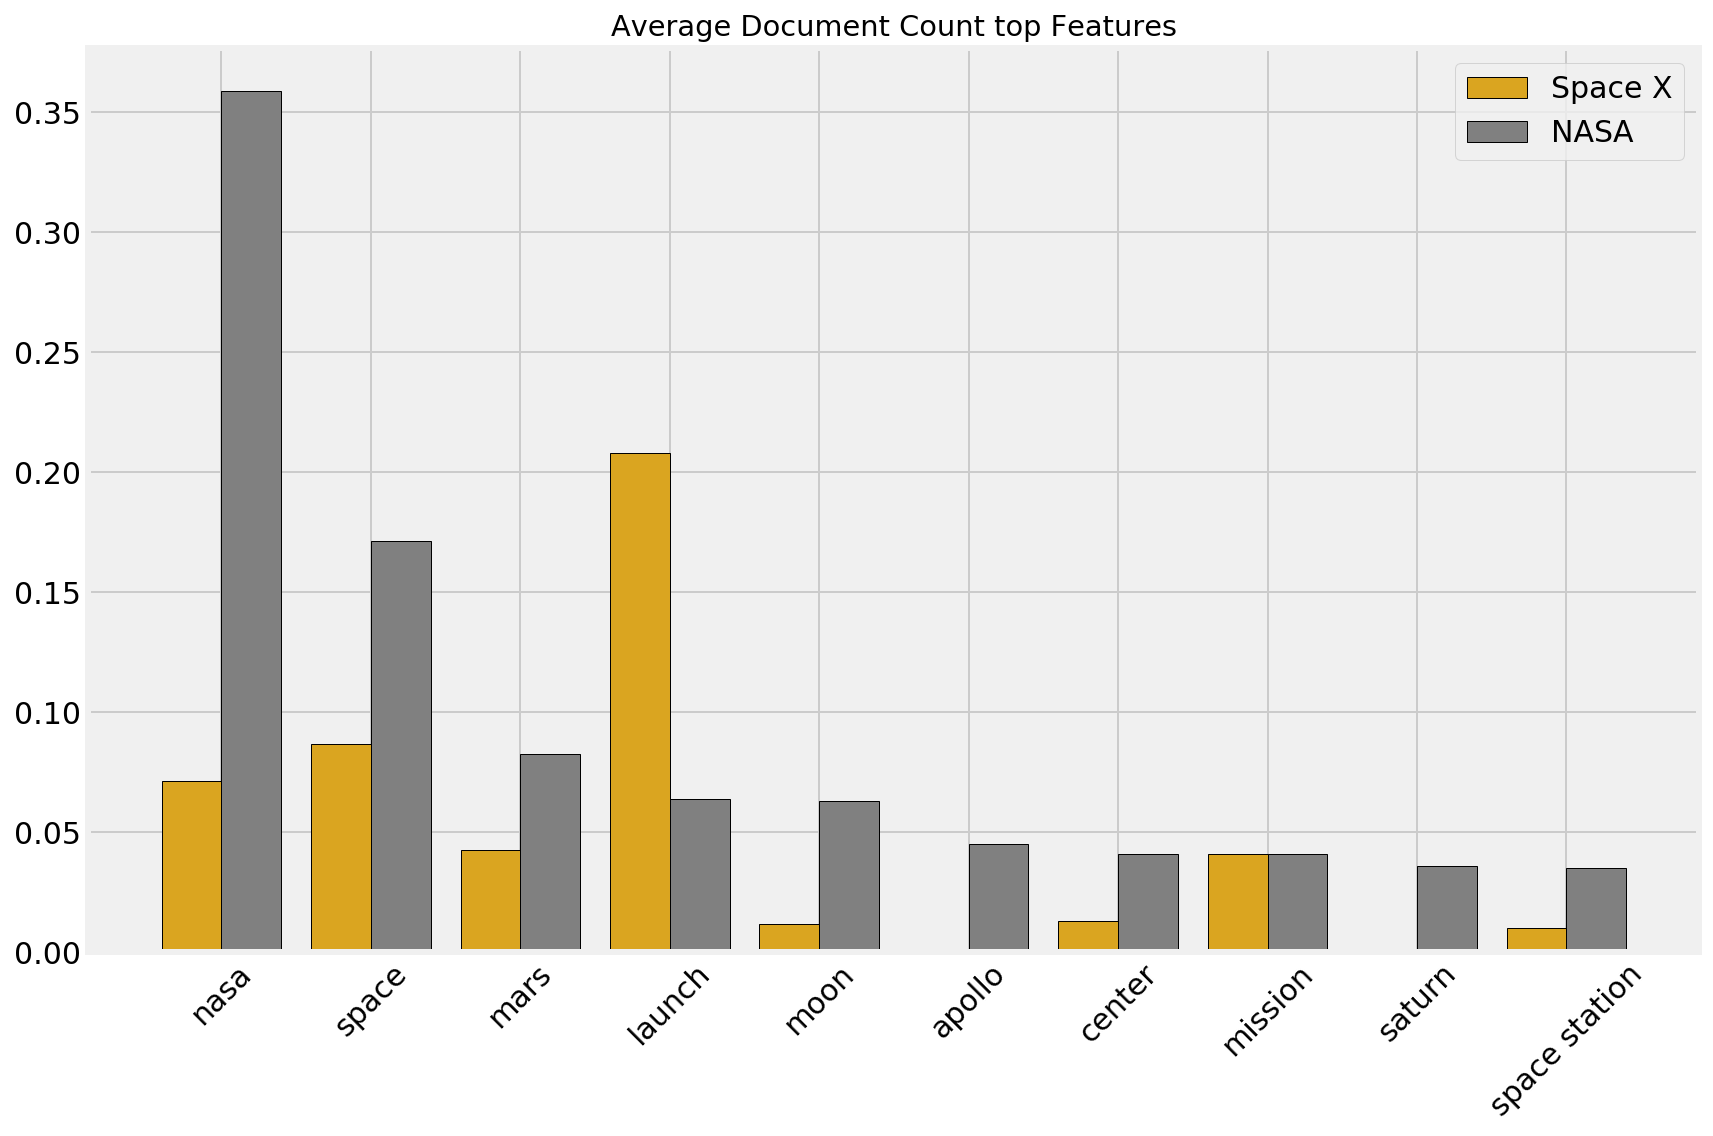

In [20]:
plt.figure(figsize=(12,8))
locs, labels = plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.setp(labels, rotation=45)
plt.title('Average Document Count top Features')
plt.bar(cvec_nasa_mean_df.index, cvec_nasa_mean_df[['spacex']].T.values[0], alpha=1, align='edge', width=-.4, ec='k', color='goldenrod')
plt.bar(cvec_nasa_mean_df.index, cvec_nasa_mean_df[['nasa']].T.values[0], alpha=1, align='edge', width=.4, ec='k', color='grey')
plt.legend(['Space X', 'NASA'], prop={'size': 15})
plt.tight_layout();
plt.savefig('../plots/cvec_mean_sorted_nasa')

### Step # 3:  Instantiate and fit TfidfVectorizer

After analyzing the CountVectorizer I want to now understand the vocabulary word frequencies of the most commonly mentioned words. To do this we use TfidfVectorizer which calculates two things:
1. Term Frequency : A summation of how often a word is mentioned within a post
2. Inverse Document Frequency : A scaling mechanism to down scale words that appear across a lot or all of the posts

This method allows me to understand which of the feaures (vocabulary words) hold the most weight in identifying whether a post originated from either Space X or NASA. This is performed by identifying which words appear the most within the posts and then down scaling the words that are common amougst all of the posts. These words are down scaled because they are not helping with the identification because they are in both subreddit posts. 

#### Hyperparameter Description

To assit in getting the most optimal vocabulary words or phrases I will ensure the TfidfVecrotizer does the following:
- Removes basic words that are common in the english language
    - stop_words = 'english'
- Looks through each word and each word that follows the word as seperate features
    - ngram_range = (1,2)
        - Example: falcon / falcon heavy
- Ensure that we only perform a tfidf on words that have a frequency within the posts of 1.0 %
    - min_df = 0.01

In [21]:
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.01)

In [22]:
tvec_mat = tvec.fit_transform(df_final['title'])

In [23]:
tvec_df = pd.DataFrame(tvec_mat.toarray(), columns=tvec.get_feature_names())

In [24]:
tvec_df.head()

,11,12,15,2018,39a,40,air,air force,amp,apollo,...,thread,time,today,twitter,vab,vehicle,video,view,year,years
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.600783,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.868537,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.387832,0.0,0.0,0.0,0.0,0.476247,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.307456,0.0,0.0,0.0,0.0,...,0.000000,0.304733,0.0,0.267847,0.0,0.0,0.0,0.0,0.000000,0.0


#### Interpretation (Space X)

In order to analyze the vocabulary words with the most weight within the posts I will add in a column that puts in our target variable so that we can understand which words have the most weight within the posts of Space X and NASA.

Using the TfidfVectorizer we can now examine which words have the most weight or largest affect on identifying whether a post came from the Space X or NASA subreddit. This infomation will be explicitly fed into our model for use in making the most optimal predictions.

Noteworthy vocabulary words that held the most weight within the Space X subreddit posts:
1. Falcon
2. Launch
3. Heavy
4. Dragon
5. Falcon Heavy

In [25]:
tvec_df['subreddit'] = df_final['subreddit'].values

In [26]:
tvec_spacex_sum_df = tvec_df.groupby('subreddit').sum().T.sort_values('spacex', ascending=False).head(10)
tvec_spacex_sum_df

subreddit,nasa,spacex
spacex,7.925167,217.631927
falcon,1.322425,116.572865
launch,31.047067,90.659084
heavy,3.503317,49.768488
dragon,4.319305,49.107686
falcon heavy,0.853401,48.589117
crew,8.304550,46.523970
space,94.748477,45.531774
block,1.836078,40.870322
rocket,16.053327,38.643895


In [27]:
tvec_spacex_sum_df[['spacex']].T.values[0]

array([217.63192702, 116.57286486,  90.65908359,  49.76848843,
        49.10768572,  48.5891174 ,  46.52397008,  45.53177433,
        40.87032182,  38.6438952 ])

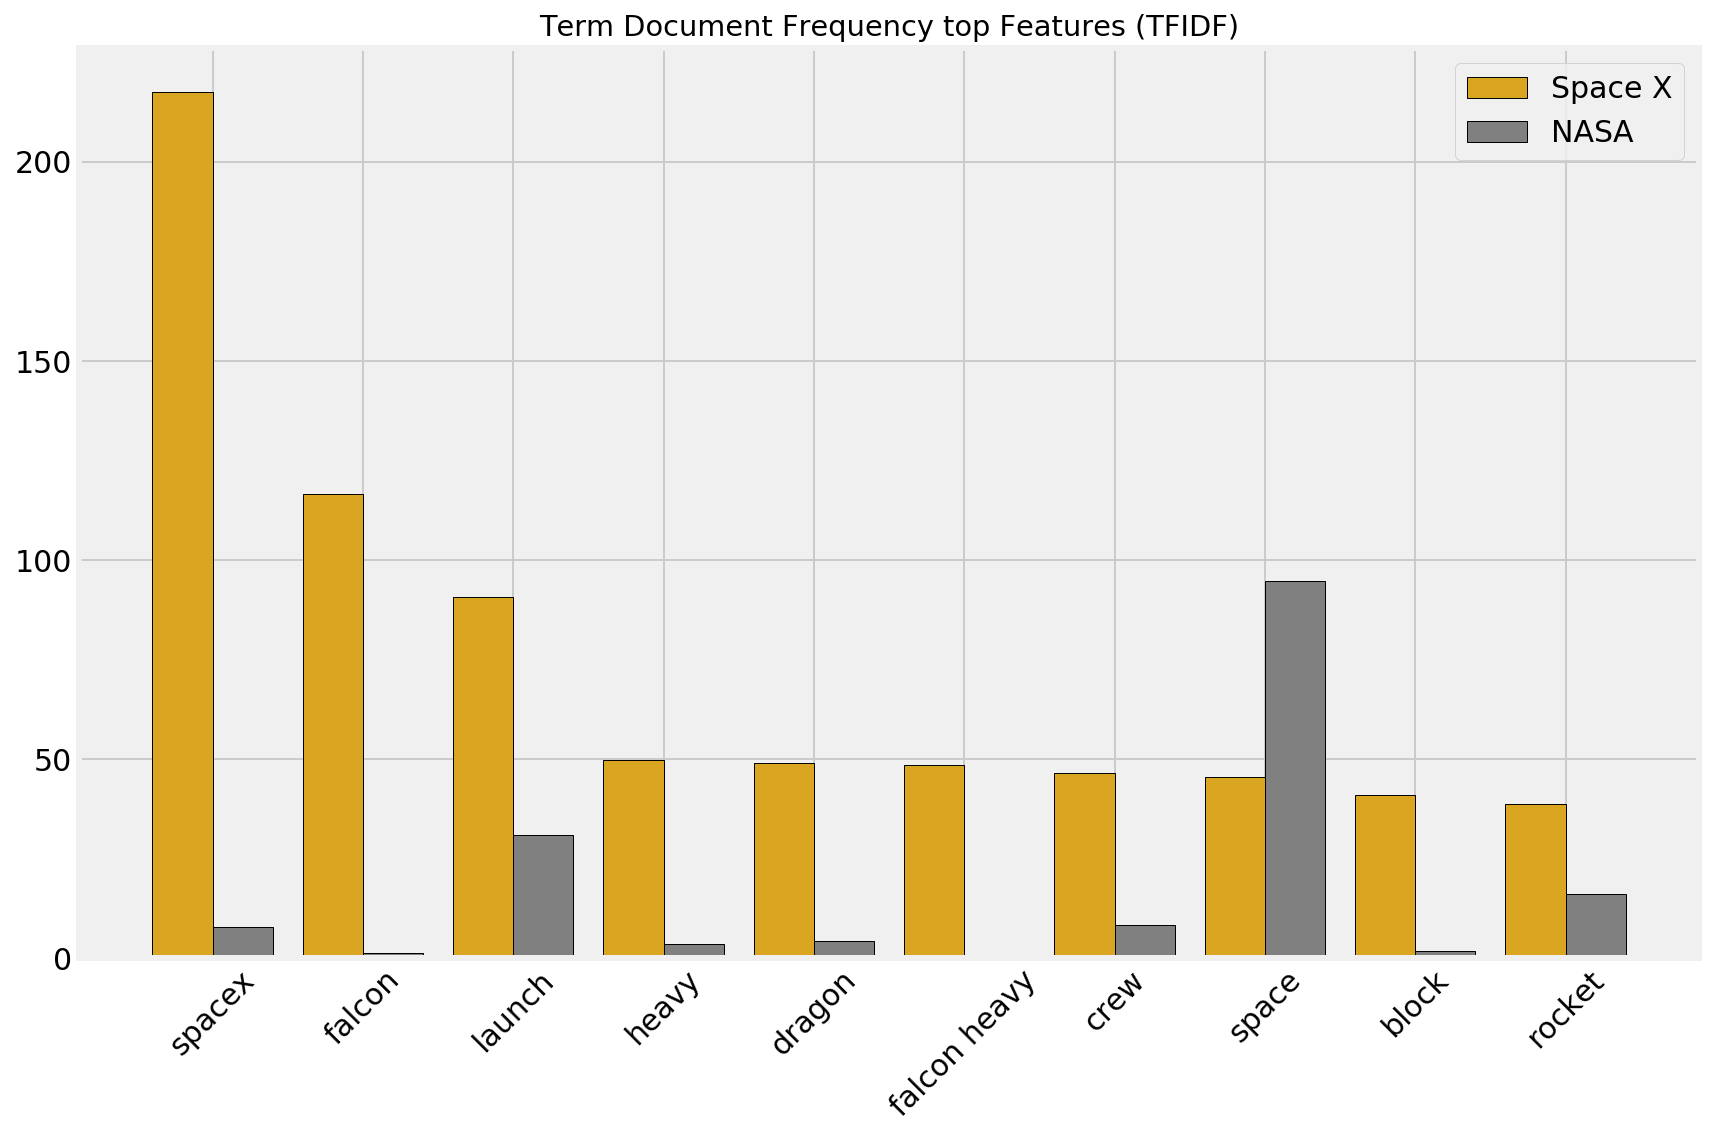

In [28]:
plt.figure(figsize=(12,8))
#sns.set_style(style='darkgrid')
locs, labels = plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.setp(labels, rotation=45)
plt.title('Term Document Frequency top Features (TFIDF)')
plt.bar(tvec_spacex_sum_df.index, tvec_spacex_sum_df[['spacex']].T.values[0], alpha=1, align='edge', width=-.4, ec='k', color='goldenrod')
plt.bar(tvec_spacex_sum_df.index, tvec_spacex_sum_df[['nasa']].T.values[0], alpha=1, align='edge', width=.4, ec='k', color='grey')
plt.legend(['Space X', 'NASA'], prop={'size': 15})
plt.tight_layout();
plt.savefig('../plots/tvec_sorted_spacex')

#### Interpretation (NASA)

Using the TfidfVectorizer we can now examine which words have the most weight or largest affect on identifying whether a post came from the Space X or NASA subreddit. This infomation will be explicitly fed into our model for use in making the most optimal predictions.

Noteworthy vocabulary words that held the most weight within the NASA subreddit posts:
1. Space
2. Mars
3. Moon
4. Apollo
5. Launch

In [29]:
tvec_nasa_sum_df = tvec_df.groupby('subreddit').sum().T.sort_values('nasa', ascending=False).head(10)
tvec_nasa_sum_df

subreddit,nasa,spacex
nasa,235.243582,28.660770
space,94.748477,45.531774
mars,68.791883,26.859210
moon,53.341661,8.182446
apollo,32.017116,0.365191
launch,31.047067,90.659084
astronaut,28.660057,5.543618
new,28.641545,25.126007
saturn,26.989437,0.000000
mission,26.914995,21.933885


In [30]:
tvec_nasa_sum_df[['nasa']].T.values[0]

array([235.24358179,  94.74847677,  68.79188253,  53.34166055,
        32.0171156 ,  31.04706694,  28.66005743,  28.64154509,
        26.98943658,  26.91499492])

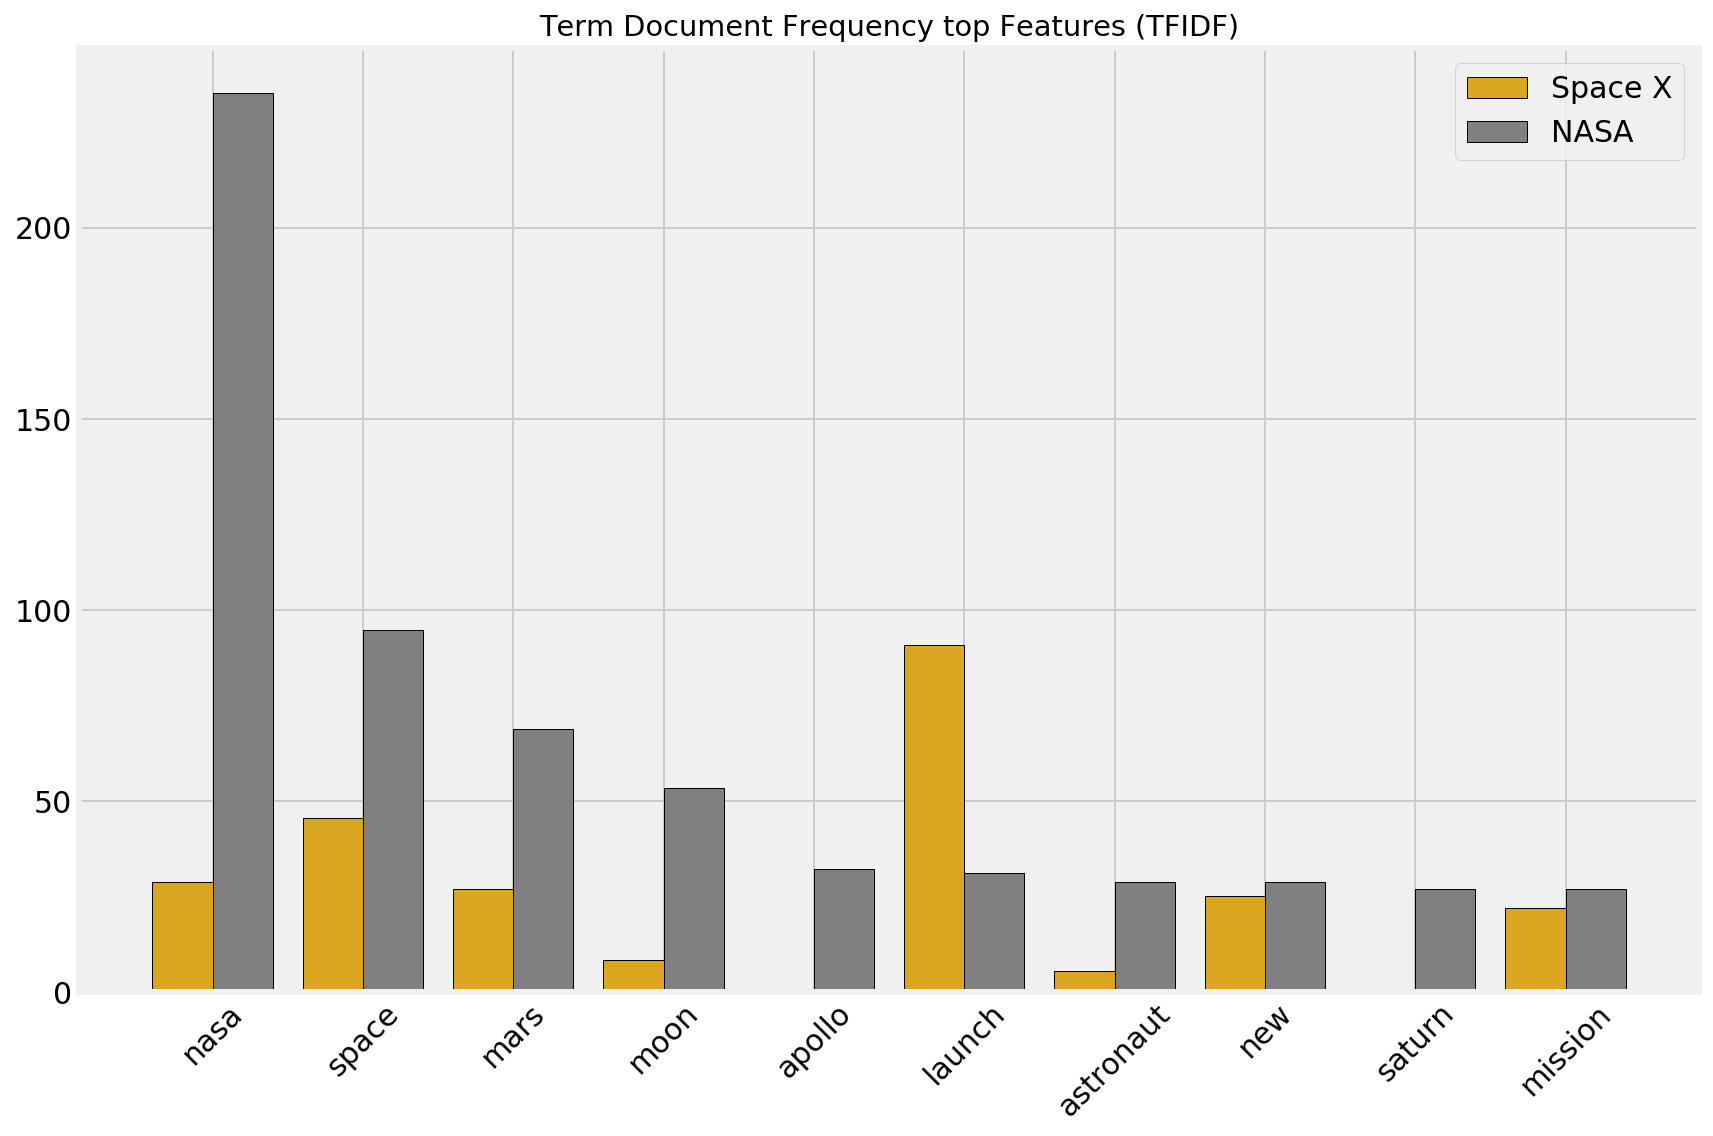

In [31]:
plt.figure(figsize=(12,8))
locs, labels = plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.setp(labels, rotation=45)
plt.title('Term Document Frequency top Features (TFIDF)')
plt.bar(tvec_nasa_sum_df.index, tvec_nasa_sum_df[['spacex']].T.values[0], alpha=1, align='edge', width=-.4, ec='k', color='goldenrod')
plt.bar(tvec_nasa_sum_df.index, tvec_nasa_sum_df[['nasa']].T.values[0], alpha=1, align='edge', width=.4, ec='k', color='grey')
plt.legend(['Space X', 'NASA'], prop={'size': 15})
plt.tight_layout();
plt.savefig('../plots/tvec_sorted_nasa')

### Step # 4 : Save & Pickle Data

In [32]:
cvec_df.to_csv('../data/cvec_df.csv', index=False)
tvec_df.to_csv('../data/tvec_df.csv', index=False)
with open('../pickles/tvec.pkl', 'wb+') as f:
    pickle.dump(tvec, f)